In [6]:
import os
os.chdir('..')

In [2]:
import tiktoken
import matplotlib.pyplot as plt
plt.style.use('default')

In [3]:
def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
    """Return the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif "gpt-3.5-turbo" in model:
        # print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
    elif "gpt-4" in model:
        # print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

In [5]:
experiment_folder_names_311 = \
'''20230817_143935_gpt-4_perturb
20230817_150630_gpt-4_perturb
20230817_154100_gpt-4_perturb
20230817_161840_gpt-4_perturb
20230817_164803_gpt-4_perturb
20230817_172216_gpt-4_perturb
20230817_180010_gpt-4_perturb
20230817_183233_gpt-4_perturb
20230817_190256_gpt-4_perturb
20230817_194010_gpt-4_perturb
20230817_200732_gpt-4_perturb
20230817_204907_gpt-4_perturb
20230817_212928_gpt-4_perturb
20230817_215932_gpt-4_perturb
20230817_223700_gpt-4_perturb
20230817_232032_gpt-4_perturb
20230817_235620_gpt-4_perturb
20230818_003229_gpt-4_perturb'''

model = 'gpt-4'
experiment_folder_names = experiment_folder_names_311.split('\n')

In [36]:
num_tokens_per_experiment =[]
for experiment_folder_name in experiment_folder_names:
    # print(experiment_folder_name)
    
    # load txt files
    file_path = 'outputs/LLM_QueryAndReply/'+experiment_folder_name+'/'
    # get all .txt file names in folder that in the format _summary.txt
    file_names = [f for f in os.listdir(file_path) if f.endswith('_summary.txt')]
    
    samples = []
    for file_name in file_names:
        file = open(file_path + file_name, 'r')
        samples.append(file.read())
        file.close()
    
    # store max num tokens in samples
    num_tokens_per_samples = []
    for sample in samples:
        reply = sample.split('REPLY:\n')[-1]
        
        num_tokens = num_tokens_from_messages([{"role": "user", "content": reply}], model=model)
        num_tokens_per_samples.append(num_tokens)
        
    # get max num tokens
    max_num_tokens = max(num_tokens_per_samples)
    
    # plt.figure()
    # plt.hist(num_tokens_per_samples, bins=20)
    # plt.title(experiment_folder_name)
    # plt.show()
    num_tokens_per_experiment.append(num_tokens_per_samples)

In [37]:
#flatten list of lists
num_tokens_per_experiment = [item for sublist in num_tokens_per_experiment for item in sublist]

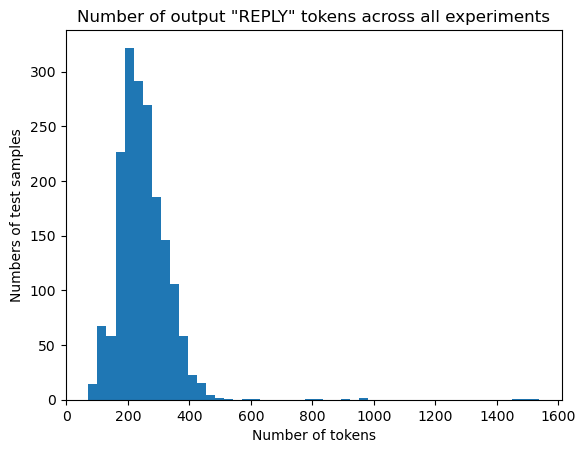

In [38]:
plt.figure()
plt.hist(num_tokens_per_experiment, bins=50)
plt.title('Number of output "REPLY" tokens across all experiments')
plt.xlabel('Number of tokens')
plt.ylabel('Numbers of test samples')
plt.show()

In [34]:
# reverse sort num tokens per experiment
num_tokens_per_experiment.sort(reverse=True)
print(num_tokens_per_experiment[0:50])

[1538, 1490, 1476, 967, 961, 905, 817, 778, 615, 592, 525, 511, 494, 479, 475, 465, 464, 452, 448, 448, 446, 442, 436, 433, 433, 430, 428, 427, 427, 426, 424, 424, 423, 422, 422, 422, 421, 420, 418, 416, 413, 412, 412, 409, 409, 408, 408, 407, 402, 400]


In [39]:
output_tokens = 550
MAX_TOKENS = 8192
input_tokens = MAX_TOKENS - output_tokens
print("input tokens", input_tokens)

input tokens 7642


In [64]:
pre_text = "Context: \"We have a two-class machine learning model that predicts based on {num_features} features: {feat_words}. The model has been trained on a dataset and has made the following predictions.\"\n\nDataset:\n```"
post_text = "\n```\nQuestion: \"Based on the model's predictions and the given dataset, what appears to be the most important feature in determining the model's prediction?\"\n\nInstructions: \"Think about the question. After explaining your reasoning, provide your answer as a feature name on the last line. Do not provide any further details on the last line.\""

COMPAS_samples = "\nInput: A = 0.107, B = 0.110, C = 0.213, D = 1, E = 0, F = 1, \nOutput: 0\n"
credit_samples = "\nInput: A = 0.125, B = 0.051, C = 0.053, D = 0.071, E = 0.222, F = 0.268, G = 0.011, H = -0.024, I = 0.207, J = 0.087, \nOutput: 0\n"
adult_samples  = "\nInput: A = 0.150, B = 0.080, C = 0.582, D = 0.036, E = 0.066, F = 0.135, G = 0, H = 1, I = 1, J = 1, K = 1, L = 0, M = 1, \nOutput: 0\n"
samples = adult_samples

In [65]:
for i in range(70, 180):
    prompt_text = pre_text + samples*i + post_text
    num_tokens = num_tokens_from_messages([{"role": "user", "content": prompt_text}], model=model)
    print(i, num_tokens)

70 6068
71 6153
72 6238
73 6323
74 6408
75 6493
76 6578
77 6663
78 6748
79 6833
80 6918
81 7003
82 7088
83 7173
84 7258
85 7343
86 7428
87 7513
88 7598
89 7683
90 7768
91 7853
92 7938
93 8023
94 8108
95 8193
96 8278
97 8363
98 8448
99 8533
100 8618
101 8703
102 8788
103 8873
104 8958
105 9043
106 9128
107 9213
108 9298
109 9383
110 9468
111 9553
112 9638
113 9723
114 9808
115 9893
116 9978
117 10063
118 10148
119 10233
120 10318
121 10403
122 10488
123 10573
124 10658
125 10743
126 10828
127 10913
128 10998
129 11083
130 11168
131 11253
132 11338
133 11423
134 11508
135 11593
136 11678
137 11763
138 11848
139 11933
140 12018
141 12103
142 12188
143 12273
144 12358
145 12443
146 12528
147 12613
148 12698
149 12783
150 12868
151 12953
152 13038
153 13123
154 13208
155 13293
156 13378
157 13463
158 13548
159 13633
160 13718
161 13803
162 13888
163 13973
164 14058
165 14143
166 14228
167 14313
168 14398
169 14483
170 14568
171 14653
172 14738
173 14823
174 14908
175 14993
176 15078
177 151

In [ ]:
# COMPAS 
# nshot tokens
# 168   7510
# 169   7554
# 170   7598 !!!
# 171   7642
# 172   7686

# Credit
# nshot tokens
# 95    7528
# 96    7606 !!!
# 97    7684
# 98    7762
# 99    7840

# adult
# 87 7513
# 88 7598 !!!
# 89 7683
# 90 7768
# 91 7853

In [68]:
text = '''
Context: "We have a two-class machine learning model that predicts based on 6 features: ['A', 'B', 'C', 'D', 'E', 'F']. The model has been trained on a dataset and has made the following predictions."

Dataset:
```
Input: A = 0.049, B = -0.057, C = -0.049, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.212, B = -0.120, C = 0.085, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.046, B = 0.065, C = -0.130, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.067, B = -0.085, C = 0.259, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.107, B = 0.205, C = -0.029, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.042, B = 0.076, C = -0.020, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.013, B = 0.036, C = 0.138, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.069, B = -0.084, C = 0.095, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.123, B = -0.118, C = -0.137, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.177, B = 0.023, C = -0.161, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.213, B = -0.002, C = -0.076, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.015, B = 0.071, C = 0.153, D = 1, E = 1, F = 0, 
Output: 0

Input: A = -0.124, B = -0.092, C = 0.134, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.116, B = -0.011, C = -0.047, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.278, B = 0.038, C = 0.194, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.005, B = 0.064, C = 0.004, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.052, B = 0.101, C = 0.124, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.141, B = -0.255, C = -0.050, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.179, B = 0.149, C = 0.137, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.089, B = 0.059, C = 0.013, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.034, B = -0.186, C = -0.147, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.067, B = 0.129, C = -0.016, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.025, B = 0.021, C = -0.061, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.164, B = 0.137, C = -0.046, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.120, B = -0.200, C = 0.021, D = 1, E = 0, F = 1, 
Output: 1

Input: A = -0.057, B = 0.132, C = 0.031, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.040, B = -0.085, C = 0.147, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.006, B = 0.090, C = -0.139, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.121, B = 0.059, C = -0.006, D = 1, E = 1, F = 0, 
Output: 0

Input: A = 0.072, B = 0.174, C = -0.063, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.103, B = 0.084, C = -0.129, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.098, B = -0.342, C = -0.093, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.097, B = 0.122, C = 0.180, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.047, B = 0.261, C = -0.014, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.108, B = -0.169, C = 0.153, D = 1, E = 0, F = 1, 
Output: 1

Input: A = 0.096, B = 0.058, C = -0.016, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.068, B = -0.044, C = 0.037, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.164, B = -0.147, C = -0.006, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.046, B = 0.142, C = -0.042, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.095, B = 0.163, C = 0.269, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.063, B = 0.131, C = -0.031, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.057, B = -0.023, C = -0.147, D = 0, E = 0, F = 0, 
Output: 1

Input: A = -0.213, B = -0.046, C = -0.059, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.036, B = -0.024, C = -0.041, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.122, B = 0.295, C = -0.018, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.021, B = -0.016, C = -0.051, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.043, B = -0.036, C = 0.246, D = 0, E = 0, F = 0, 
Output: 0

Input: A = 0.027, B = -0.132, C = 0.103, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.012, B = -0.094, C = 0.195, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.030, B = 0.101, C = -0.045, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.079, B = 0.004, C = 0.043, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.090, B = 0.091, C = 0.077, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.049, B = -0.021, C = 0.104, D = 1, E = 0, F = 1, 
Output: 0

Input: A = -0.020, B = 0.118, C = 0.004, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.082, B = -0.059, C = -0.034, D = 1, E = 1, F = 0, 
Output: 1

Input: A = 0.116, B = 0.114, C = 0.089, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.037, B = 0.057, C = -0.171, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.016, B = 0.001, C = 0.018, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.088, B = -0.148, C = 0.091, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.096, B = 0.006, C = 0.027, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.020, B = -0.172, C = 0.107, D = 0, E = 0, F = 1, 
Output: 1

Input: A = 0.147, B = -0.055, C = 0.102, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.094, B = 0.042, C = 0.089, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.149, B = 0.061, C = 0.096, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.091, B = 0.080, C = -0.024, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.059, B = 0.028, C = 0.103, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.176, B = 0.028, C = 0.085, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.003, B = 0.054, C = 0.044, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.106, B = -0.017, C = 0.060, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.084, B = -0.127, C = 0.053, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.049, B = -0.201, C = -0.055, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.038, B = 0.216, C = 0.050, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.107, B = 0.257, C = -0.121, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.205, B = 0.051, C = -0.184, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.068, B = 0.091, C = 0.064, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.137, B = 0.080, C = -0.087, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.194, B = 0.060, C = 0.186, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.089, B = -0.073, C = -0.186, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.101, B = -0.005, C = 0.045, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.167, B = 0.001, C = -0.008, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.064, B = 0.002, C = -0.108, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.063, B = 0.218, C = 0.045, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.095, B = -0.108, C = 0.122, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.086, B = -0.038, C = -0.026, D = 1, E = 1, F = 0, 
Output: 1

Input: A = -0.012, B = 0.034, C = 0.063, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.172, B = 0.020, C = -0.077, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.099, B = 0.053, C = -0.268, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.086, B = 0.120, C = -0.043, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.027, B = 0.184, C = -0.148, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.059, B = 0.166, C = -0.011, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.047, B = -0.111, C = -0.052, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.038, B = 0.095, C = -0.016, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.085, B = 0.005, C = 0.080, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.053, B = 0.164, C = 0.033, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.021, B = -0.081, C = 0.108, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.013, B = 0.034, C = 0.070, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.071, B = 0.117, C = 0.117, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.038, B = 0.088, C = 0.001, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.093, B = 0.061, C = 0.025, D = 1, E = 1, F = 1, 
Output: 0

Input: A = -0.040, B = 0.171, C = 0.110, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.178, B = 0.100, C = 0.159, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.216, B = -0.030, C = 0.087, D = 1, E = 0, F = 1, 
Output: 1

Input: A = -0.012, B = -0.099, C = -0.121, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.054, B = 0.067, C = 0.020, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.040, B = 0.150, C = 0.024, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.026, B = 0.130, C = 0.139, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.119, B = 0.183, C = 0.054, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.035, B = -0.037, C = -0.101, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.136, B = 0.068, C = 0.153, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.007, B = -0.055, C = -0.086, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.127, B = -0.082, C = -0.026, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.047, B = 0.067, C = -0.034, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.010, B = 0.110, C = 0.107, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.213, B = 0.083, C = -0.159, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.059, B = -0.039, C = -0.059, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.062, B = 0.110, C = 0.003, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.095, B = 0.198, C = 0.017, D = 1, E = 1, F = 0, 
Output: 0

Input: A = 0.143, B = -0.036, C = 0.134, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.086, B = 0.090, C = 0.060, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.077, B = 0.126, C = 0.133, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.018, B = 0.064, C = 0.153, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.198, B = 0.063, C = 0.012, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.159, B = -0.126, C = 0.140, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.136, B = 0.022, C = 0.034, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.091, B = -0.013, C = 0.072, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.152, B = 0.043, C = -0.027, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.265, B = -0.030, C = 0.073, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.119, B = 0.038, C = 0.004, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.230, B = 0.148, C = -0.137, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.060, B = 0.043, C = 0.010, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.013, B = -0.055, C = -0.097, D = 1, E = 0, F = 1, 
Output: 0

Input: A = -0.077, B = 0.232, C = -0.029, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.112, B = 0.001, C = 0.143, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.110, B = -0.022, C = -0.113, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.206, B = -0.089, C = -0.003, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.054, B = 0.050, C = 0.108, D = 1, E = 0, F = 1, 
Output: 0

Input: A = -0.097, B = 0.043, C = -0.056, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.041, B = -0.001, C = -0.132, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.139, B = 0.117, C = 0.143, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.004, B = -0.182, C = -0.020, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.082, B = -0.150, C = 0.055, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.031, B = -0.004, C = -0.039, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.062, B = 0.151, C = -0.017, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.276, B = 0.086, C = 0.038, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.091, B = 0.068, C = 0.184, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.150, B = -0.045, C = 0.055, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.081, B = 0.004, C = 0.083, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.071, B = 0.012, C = 0.107, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.170, B = 0.050, C = 0.066, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.143, B = 0.025, C = 0.124, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.131, B = -0.065, C = -0.002, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.079, B = 0.138, C = -0.086, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.173, B = 0.190, C = 0.085, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.078, B = 0.058, C = 0.008, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.114, B = 0.102, C = 0.071, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.198, B = 0.110, C = 0.047, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.118, B = -0.181, C = 0.113, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.053, B = 0.119, C = 0.011, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.090, B = 0.061, C = 0.104, D = 1, E = 0, F = 0, 
Output: 0

Input: A = -0.140, B = -0.001, C = -0.278, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.003, B = -0.110, C = -0.239, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.086, B = -0.037, C = 0.071, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.033, B = 0.052, C = -0.003, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.061, B = 0.122, C = 0.056, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.014, B = 0.092, C = 0.055, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.056, B = 0.019, C = 0.096, D = 1, E = 1, F = 1, 
Output: 0

Input: A = 0.129, B = -0.019, C = -0.069, D = 1, E = 0, F = 0, 
Output: 1

Input: A = 0.056, B = 0.024, C = 0.167, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.290, B = 0.083, C = 0.135, D = 1, E = 0, F = 0, 
Output: 1

Input: A = -0.033, B = -0.095, C = 0.164, D = 1, E = 0, F = 0, 
Output: 0
```

Question: "Based on the model's predictions and the given dataset, what appears to be the top five most important features in determining the model's prediction?"

Instructions: "Think about the question. After explaining your reasoning, provide your answer as the top five most important features ranked from most important to least important, in descending order. Only provide the feature names on the last line. Do not provide any further details on the last line."
'''
num_tokens_from_messages([{"role": "user", "content": text}], model=model)

7633

In [50]:
text = '''
Context: "We have a two-class machine learning model that predicts based on 6 features: ['A', 'B', 'C', 'D', 'E', 'F']. The model has been trained on a dataset and has made the following predictions."

Dataset:
```
Input: A = 0.123, B = 0.549, C = 0.165, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.141, B = 0.618, C = -0.039, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.005, B = 0.651, C = 0.077, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.101, B = 0.871, C = 0.121, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.052, B = 0.772, C = 0.153, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.225, B = 0.645, C = 0.127, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.181, B = 0.810, C = 0.031, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.080, B = 0.944, C = 0.179, D = 1, E = 1, F = 1, 
Output: 0

Input: A = 0.376, B = 0.768, C = 0.113, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.245, B = 0.825, C = 0.055, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.507, B = 0.569, C = 0.019, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.061, B = 0.813, C = -0.130, D = 1, E = 0, F = 1, 
Output: 0

Input: A = -0.103, B = 0.644, C = -0.175, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.037, B = 0.760, C = -0.009, D = 1, E = 1, F = 1, 
Output: 0

Input: A = 0.199, B = 0.657, C = -0.044, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.058, B = 0.632, C = -0.015, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.131, B = 0.694, C = 0.081, D = 1, E = 0, F = 1,
Output: 
Most important feature: 
```

Question: "Based on the model's predictions and the given dataset, estimate the model's prediction for the last input. What appears to be the most important feature in determining the model's prediction?"

Instructions: "Think about the question. After explaining your reasoning, provide your answer as a feature name on the last line. Do not provide any further details on the last line."
'''
num_tokens_from_messages([{"role": "user", "content": text}], model=model)

891

In [51]:
text = '''
Context: "We have a two-class machine learning model that predicts based on 6 features: ['A', 'B', 'C', 'D', 'E', 'F']. The model has been trained on a dataset and has made the following predictions."

Dataset:
```
Input: A = 0.12, B = 0.54, C = 0.16, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.14, B = 0.61, C = -0.03, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.00, B = 0.65, C = 0.77, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.10, B = 0.87, C = 0.12, D = 1, E = 0, F = 0, 
Output: 0

Input: A = 0.05, B = 0.77, C = 0.13, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.22, B = 0.64, C = 0.12, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.18, B = 0.81, C = 0.03, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.08, B = 0.94, C = 0.19, D = 1, E = 1, F = 1, 
Output: 0

Input: A = 0.37, B = 0.76, C = 0.11, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.24, B = 0.82, C = 0.05, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.50, B = 0.56, C = 0.01, D = 0, E = 0, F = 0, 
Output: 1

Input: A = 0.06, B = 0.81, C = -0.13, D = 1, E = 0, F = 1, 
Output: 0

Input: A = -0.10, B = 0.64, C = -0.17, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.03, B = 0.76, C = -0.01, D = 1, E = 1, F = 1, 
Output: 0

Input: A = 0.19, B = 0.65, C = -0.04, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.05, B = 0.63, C = -0.01, D = 1, E = 0, F = 1, 
Output: 0

Input: A = 0.13, B = 0.69, C = 0.08, D = 1, E = 0, F = 1,
Output: 
Most important feature: 
```

Question: "Based on the model's predictions and the given dataset, estimate the model's prediction for the last input. What appears to be the most important feature in determining the model's prediction?"

Instructions: "Think about the question. After explaining your reasoning, provide your answer as a feature name on the last line. Do not provide any further details on the last line."
'''
num_tokens_from_messages([{"role": "user", "content": text}], model=model)

891